In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from lightgbm.sklearn import LGBMClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse
from scipy.stats import kurtosis
import time
import warnings
import datetime
import matplotlib.pylab as plt
from sklearn.cluster import KMeans
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.rcParams['font.sans-serif'] = ['SimHei']

In [84]:
import pandarallel as pdl
pdl.pandarallel.initialize(10000)

ModuleNotFoundError: No module named 'pyarrow._plasma'

In [2]:
from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()

In [3]:
train_df = pd.read_csv('dataset/train.csv', parse_dates=['auditing_date', 'due_date', 'repay_date'])

In [4]:
train_df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,repay_date,repay_amt
0,748147,3163926,2018-04-25,2018-05-25,72.1167,2018-05-25,72.1167
1,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-07-08,258.7045
2,404196,2355665,2018-02-18,2018-03-18,307.9270,\N,\N
3,342769,1994522,2018-01-13,2018-02-13,252.9809,2018-02-13,252.9809
4,828139,3602352,2018-06-01,2018-07-01,107.6503,2018-06-25,107.6503


In [5]:
def plus_1_day(s):
    return s + datetime.timedelta(days=1)

In [6]:
# 如果违约,还款日期为due_date的后一天
train_df['repay_date'] = train_df[['due_date', 'repay_date']].apply(
    lambda x: x['repay_date'] if x['repay_date'] != '\\N' else plus_1_day(x['due_date']), axis=1
)

In [7]:
# 如果违约,还款金额为0
train_df['repay_amt'] = train_df['repay_amt'].apply(lambda x: x if x != '\\N' else 0).astype('float32')

In [8]:
# 设定label
train_df['label'] = (train_df['due_date'] - train_df['repay_date']).dt.days

In [9]:
train_df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,repay_date,repay_amt,label
0,748147,3163926,2018-04-25,2018-05-25,72.1167,2018-05-25,72.116699,0
1,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-07-08,258.704498,1
2,404196,2355665,2018-02-18,2018-03-18,307.9270,2018-03-19,0.000000,-1
3,342769,1994522,2018-01-13,2018-02-13,252.9809,2018-02-13,252.980896,0
4,828139,3602352,2018-06-01,2018-07-01,107.6503,2018-06-25,107.650299,6


In [10]:
train_df['label'].value_counts(sort=False)

 0     408187
 1     121085
 2      59430
 3      56404
 4      26425
 5      21380
 6      17568
 7      14797
 8      12993
 9      11393
 10      9984
 11      9002
 12      8219
 13      7688
 14      6920
 15      6443
 16      6231
 17      5832
 18      5492
 19      5108
 20      4788
 21      4504
 22      4295
 23      4197
 24      3922
 25      3934
 26      3930
 27      4102
 28      4677
 29      5645
 30      9865
 31      8368
-1     117192
Name: label, dtype: int64

In [11]:
train_df['label'].nunique()

33

In [12]:
# 为什么要把-1换作32:方便分类编号和日期对应
# train_df.loc[train_df['repay_amt'] == -1, 'label'] = 32 错误写法
train_df['label'].replace(-1, 32, inplace=True)

In [13]:
clf_labels = train_df['label'].values

In [14]:
clf_labels.shape

(1000000,)

In [15]:
amt_labels = train_df['repay_amt'].values

In [16]:
del train_df['label'], train_df['repay_amt'], train_df['repay_date']

In [17]:
train_due_amt_df = train_df[['due_amt']]

In [18]:
train_num = train_df.shape[0]

In [19]:
test_df = pd.read_csv('dataset/test.csv', parse_dates=['auditing_date', 'due_date'])

In [20]:
test_df.head()

,user_id,listing_id,auditing_date,due_date,due_amt
0,498765,5431438,2019-03-12,2019-04-12,138.5903
1,34524,5443211,2019-03-15,2019-04-15,208.0805
2,821741,5461707,2019-03-22,2019-04-22,421.2097
3,263534,5472320,2019-03-26,2019-04-26,212.6537
4,238853,5459750,2019-03-21,2019-04-21,817.4593


In [21]:
sub = test_df[['user_id', 'listing_id', 'auditing_date', 'due_amt', 'due_date']]

In [22]:
sub.head()

,user_id,listing_id,auditing_date,due_amt,due_date
0,498765,5431438,2019-03-12,138.5903,2019-04-12
1,34524,5443211,2019-03-15,208.0805,2019-04-15
2,821741,5461707,2019-03-22,421.2097,2019-04-22
3,263534,5472320,2019-03-26,212.6537,2019-04-26
4,238853,5459750,2019-03-21,817.4593,2019-04-21


In [23]:
test_df.shape

(130000, 5)

In [24]:
df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

In [25]:
df.shape

(1130000, 5)

In [26]:
df_listing_id = df['listing_id']

In [27]:
# 时间对比控制不用未来的数据
def merge_before_auditing(df, df2, df2_time='info_insert_date', on='user_id'):
    df3 = df.merge(df2, on=on, how='left')
    df4 = df3[(df3['auditing_date']>df3[df2_time])]
    df5 = df.merge(df4, on=df.columns.tolist(), how='left')
    return df5

# *listing_info*

In [28]:
listing_info_df = pd.read_csv('dataset/listing_info.csv', parse_dates=['auditing_date'])

In [29]:
listing_info_df['principal_per_term'] = listing_info_df['principal'] / listing_info_df['term']

In [30]:
listing_info_df.head()

,user_id,listing_id,auditing_date,term,rate,principal,principal_per_term
0,316610,1556649,2017-11-26,9,7.6,4800,533.333333
1,62002,1556633,2017-11-26,6,7.6,4000,666.666667
2,192135,1556629,2017-11-26,12,8.0,8660,721.666667
3,487382,1556628,2017-11-26,9,7.6,4780,531.111111
4,235186,1556627,2017-11-26,9,7.6,1480,164.444444


## 历史贷款信息的统计特征

In [31]:
listing_hist_df = listing_info_df.drop(columns=['listing_id'])
listing_hist_df.rename({'auditing_date': 'hist_auditing_date'},axis=1,inplace=True)

In [32]:
df = merge_before_auditing(df, listing_hist_df, df2_time='hist_auditing_date', on="user_id")

In [33]:
df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,hist_auditing_date,term,rate,principal,principal_per_term
0,748147,3163926,2018-04-25,2018-05-25,72.1167,2018-04-22,12.0,8.6,1170.0,97.500000
1,672952,3698760,2018-06-09,2018-07-09,258.7045,2017-11-10,6.0,8.0,5540.0,923.333333
2,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-04-12,9.0,7.2,1170.0,130.000000
3,672952,3698760,2018-06-09,2018-07-09,258.7045,2017-09-29,3.0,8.0,1710.0,570.000000
4,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-06-05,6.0,8.6,2260.0,376.666667


In [34]:
# 总估算利息
df['interest']=(1+df['term'])*df['principal']*df['rate']/24

In [35]:
groups = df.groupby('listing_id', as_index=False)

In [36]:
# 历史借款数
df = df.merge(groups['principal'].agg({'hist_loans': len}))

In [ ]:
# 'pricipal'为空时历史借款数为0
df.loc[df['pricipal'].isnull(),'hist_loans']=0

In [37]:
df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,hist_auditing_date,term,rate,principal,principal_per_term,interest,hist_loans
0,748147,3163926,2018-04-25,2018-05-25,72.1167,2018-04-22,12.0,8.6,1170.0,97.500000,5450.250000,1.0
1,672952,3698760,2018-06-09,2018-07-09,258.7045,2017-11-10,6.0,8.0,5540.0,923.333333,12926.666667,9.0
2,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-04-12,9.0,7.2,1170.0,130.000000,3510.000000,9.0
3,672952,3698760,2018-06-09,2018-07-09,258.7045,2017-09-29,3.0,8.0,1710.0,570.000000,2280.000000,9.0
4,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-06-05,6.0,8.6,2260.0,376.666667,5668.833333,9.0


In [38]:
# 历史总估算利息统计
df = df.merge(groups['interest'].agg({
    'hist_interest_mean':'mean', 'hist_interest_median':'median', 'hist_interest_std':'std', 'hist_interest_max':'max', 
    'hist_interest_min':'min', 'hist_interest_skew':'skew', 'hist_interest_sum':'sum'
}))

In [39]:
df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,hist_auditing_date,term,rate,principal,principal_per_term,interest,hist_loans,hist_interest_mean,hist_interest_median,hist_interest_std,hist_interest_max,hist_interest_min,hist_interest_skew,hist_interest_sum
0,748147,3163926,2018-04-25,2018-05-25,72.1167,2018-04-22,12.0,8.6,1170.0,97.500000,5450.250000,1.0,5450.250000,5450.25,NaN,5450.250000,5450.25,NaN,5450.25
1,672952,3698760,2018-06-09,2018-07-09,258.7045,2017-11-10,6.0,8.0,5540.0,923.333333,12926.666667,9.0,5386.166667,3510.00,3251.016384,12926.666667,2280.00,1.767087,48475.50
2,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-04-12,9.0,7.2,1170.0,130.000000,3510.000000,9.0,5386.166667,3510.00,3251.016384,12926.666667,2280.00,1.767087,48475.50
3,672952,3698760,2018-06-09,2018-07-09,258.7045,2017-09-29,3.0,8.0,1710.0,570.000000,2280.000000,9.0,5386.166667,3510.00,3251.016384,12926.666667,2280.00,1.767087,48475.50
4,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-06-05,6.0,8.6,2260.0,376.666667,5668.833333,9.0,5386.166667,3510.00,3251.016384,12926.666667,2280.00,1.767087,48475.50


In [40]:
# 历史借款值统计
df = df.merge(groups['principal'].agg({
    'hist_principal_mean':'mean', 'hist_principal_median':'median', 'hist_principal_std':'std', 'hist_principal_max':'max', 
    'hist_principal_min':'min', 'hist_principal_skew':'skew', 'hist_principal_sum':'sum'
}))

In [41]:
# 历史期数统计
df = df.merge(groups['term'].agg({
    'hist_term_mean':'mean', 'hist_term_median':'median', 'hist_term_std':'std', 'hist_term_max':'max', 
    'hist_term_min':'min', 'hist_term_skew':'skew', 'hist_term_sum':'sum'
}))

In [42]:
# 留下最新的'hist_auditing_date’数据，计算距离最近一次贷款的天数
df = df.sort_values(by='hist_auditing_date', ascending=False).drop_duplicates('listing_id').sort_index().reset_index(drop=True)

In [43]:
df['days_after_last_loan'] = (df['auditing_date']-df['hist_auditing_date']).dt.days

In [44]:
del df['hist_auditing_date'], df['term'], df['rate'], df['principal'], df['interest']

## 当前贷款信息的特征

In [45]:
del listing_info_df['user_id'], listing_info_df['auditing_date']

In [46]:
listing_info_df.head()

,listing_id,term,rate,principal,principal_per_term
0,1556649,9,7.6,4800,533.333333
1,1556633,6,7.6,4000,666.666667
2,1556629,12,8.0,8660,721.666667
3,1556628,9,7.6,4780,531.111111
4,1556627,9,7.6,1480,164.444444


In [47]:
listing_info_df.head()

,listing_id,term,rate,principal,principal_per_term
0,1556649,9,7.6,4800,533.333333
1,1556633,6,7.6,4000,666.666667
2,1556629,12,8.0,8660,721.666667
3,1556628,9,7.6,4780,531.111111
4,1556627,9,7.6,1480,164.444444


In [48]:
df = df.merge(listing_info_df, on='listing_id', how='left')

In [49]:
df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,principal_per_term_x,hist_loans,hist_interest_mean,hist_interest_median,hist_interest_std,hist_interest_max,hist_interest_min,hist_interest_skew,hist_interest_sum,hist_principal_mean,hist_principal_median,hist_principal_std,hist_principal_max,hist_principal_min,hist_principal_skew,hist_principal_sum,hist_term_mean,hist_term_median,hist_term_std,hist_term_max,hist_term_min,hist_term_skew,hist_term_sum,days_after_last_loan,term,rate,principal,principal_per_term_y
0,748147,3163926,2018-04-25,2018-05-25,72.1167,97.500000,1.0,5450.250000,5450.250000,NaN,5450.250000,5450.250000,NaN,5450.250000,1170.000000,1170.0,NaN,1170.0,1170.0,NaN,1170.0,12.000000,12.0,NaN,12.0,12.0,NaN,12.0,3.0,9,7.2,630,70.000000
1,672952,3698760,2018-06-09,2018-07-09,258.7045,376.666667,9.0,5386.166667,3510.000000,3251.016384,12926.666667,2280.000000,1.767087,48475.500000,2078.888889,1710.0,1392.753069,5540.0,1170.0,2.285902,18710.0,7.666667,9.0,2.179449,9.0,3.0,-1.500689,69.0,4.0,9,7.2,2260,251.111111
2,404196,2355665,2018-02-18,2018-03-18,307.9270,298.888889,2.0,6981.937500,6981.937500,1538.752744,8070.000000,5893.875000,NaN,13963.875000,1930.000000,1930.0,1074.802307,2690.0,1170.0,NaN,3860.0,10.500000,10.5,2.121320,12.0,9.0,NaN,21.0,21.0,9,7.2,2690,298.888889
3,342769,1994522,2018-01-13,2018-02-13,252.9809,415.555556,6.0,10157.805556,10070.333333,4067.038624,17195.000000,5668.833333,0.975149,60946.833333,3433.333333,3210.0,1341.635817,5430.0,2040.0,0.533171,20600.0,8.000000,7.5,2.449490,12.0,6.0,0.857321,48.0,31.0,9,7.2,2210,245.555556
4,828139,3602352,2018-06-01,2018-07-01,107.6503,142.500000,1.0,7687.875000,7687.875000,NaN,7687.875000,7687.875000,NaN,7687.875000,1710.000000,1710.0,NaN,1710.0,1710.0,NaN,1710.0,12.000000,12.0,NaN,12.0,12.0,NaN,12.0,58.0,6,8.6,630,105.000000


In [50]:
cate_cols2 = []

In [52]:
#df['principal_per_term'] = df['principal'] / df['term']
df['ttl_due_amt'] = df['term'] * df['due_amt']
df['ttl_interest'] = df['ttl_due_amt'] - df['principal']
df['interest_per_term'] = df['ttl_interest'] / df['term']
df['ttl_interest/ttl_due_amt'] = df['ttl_interest'] / df['ttl_due_amt']
df['principal_per_term/due_amt'] = df['principal_per_term'] / df['due_amt']
df['ttl_interest/principal'] = df['ttl_interest'] / df['principal']
df['ttl_interest/ttl_due_amt'] = df['ttl_interest'] / df['ttl_due_amt']
df['due_period'] = (df['due_date'] - df['auditing_date']).dt.days
df['due_amt_per_days'] = df['due_amt'] / df['due_period']
df['due_date星期几'] = df['due_date'].dt.dayofweek
df['auditing_date星期几'] = df['auditing_date'].dt.dayofweek
# 这2个特征下面有处理
# df['due_date是当月第几日'] = df['due_date'].dt.day
# df['auditing_date是当月第几日'] = df['auditing_date'].dt.day

In [53]:
cate_cols2.append('due_date星期几')
cate_cols2.append('auditing_date星期几')
cate_cols2.append('due_period')

In [54]:
df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,principal_per_term_x,hist_loans,hist_interest_mean,hist_interest_median,hist_interest_std,hist_interest_max,hist_interest_min,hist_interest_skew,hist_interest_sum,hist_principal_mean,hist_principal_median,hist_principal_std,hist_principal_max,hist_principal_min,hist_principal_skew,hist_principal_sum,hist_term_mean,hist_term_median,hist_term_std,hist_term_max,hist_term_min,hist_term_skew,hist_term_sum,days_after_last_loan,term,rate,principal,principal_per_term_y,principal_per_term,ttl_due_amt,ttl_interest,interest_per_term,ttl_interest/ttl_due_amt,principal_per_term/due_amt,ttl_interest/principal,due_period,due_amt_per_days,due_date星期几,auditing_date星期几
0,748147,3163926,2018-04-25,2018-05-25,72.1167,97.500000,1.0,5450.250000,5450.250000,NaN,5450.250000,5450.250000,NaN,5450.250000,1170.000000,1170.0,NaN,1170.0,1170.0,NaN,1170.0,12.000000,12.0,NaN,12.0,12.0,NaN,12.0,3.0,9,7.2,630,70.000000,70.000000,649.0503,19.0503,2.116700,0.029351,0.970649,0.030239,30,2.403890,4,2
1,672952,3698760,2018-06-09,2018-07-09,258.7045,376.666667,9.0,5386.166667,3510.000000,3251.016384,12926.666667,2280.000000,1.767087,48475.500000,2078.888889,1710.0,1392.753069,5540.0,1170.0,2.285902,18710.0,7.666667,9.0,2.179449,9.0,3.0,-1.500689,69.0,4.0,9,7.2,2260,251.111111,251.111111,2328.3405,68.3405,7.593389,0.029352,0.970648,0.030239,30,8.623483,0,5
2,404196,2355665,2018-02-18,2018-03-18,307.9270,298.888889,2.0,6981.937500,6981.937500,1538.752744,8070.000000,5893.875000,NaN,13963.875000,1930.000000,1930.0,1074.802307,2690.0,1170.0,NaN,3860.0,10.500000,10.5,2.121320,12.0,9.0,NaN,21.0,21.0,9,7.2,2690,298.888889,298.888889,2771.3430,81.3430,9.038111,0.029351,0.970649,0.030239,28,10.997393,6,6
3,342769,1994522,2018-01-13,2018-02-13,252.9809,415.555556,6.0,10157.805556,10070.333333,4067.038624,17195.000000,5668.833333,0.975149,60946.833333,3433.333333,3210.0,1341.635817,5430.0,2040.0,0.533171,20600.0,8.000000,7.5,2.449490,12.0,6.0,0.857321,48.0,31.0,9,7.2,2210,245.555556,245.555556,2276.8281,66.8281,7.425344,0.029351,0.970649,0.030239,31,8.160674,1,5
4,828139,3602352,2018-06-01,2018-07-01,107.6503,142.500000,1.0,7687.875000,7687.875000,NaN,7687.875000,7687.875000,NaN,7687.875000,1710.000000,1710.0,NaN,1710.0,1710.0,NaN,1710.0,12.000000,12.0,NaN,12.0,12.0,NaN,12.0,58.0,6,8.6,630,105.000000,105.000000,645.9018,15.9018,2.650300,0.024620,0.975380,0.025241,30,3.588343,6,4


# *user_info*

In [55]:
user_info_df = pd.read_csv('dataset/user_info.csv', parse_dates=['reg_mon', 'insertdate'])

In [56]:
user_info_df.head()

,user_id,reg_mon,gender,age,cell_province,id_province,id_city,insertdate
0,483833,2017-04-01,男,19,c29,c26,c26241,2018-12-11
1,156772,2016-05-01,男,31,c11,c11,c11159,2018-02-13
2,173388,2016-05-01,男,34,c02,c02,c02182,2018-08-21
3,199107,2016-07-01,女,25,c09,c09,c09046,2018-06-05
4,122560,2016-03-01,男,23,c05,c05,c05193,2018-04-02


In [57]:
user_info_df.rename(columns={'insertdate': 'info_insert_date'}, inplace=True)

In [58]:
df = merge_before_auditing(df, user_info_df, df2_time='info_insert_date', on='user_id')

In [59]:
df = df.sort_values(by='info_insert_date', ascending=False).drop_duplicates('listing_id').sort_index().reset_index(drop=True)

In [60]:
df['time_bt_aud&reg'] = (df['auditing_date'] - df['reg_mon']).dt.days

In [61]:
df['time_bt_info&reg'] = (df['info_insert_date'] - df['reg_mon']).dt.days

In [62]:
df['cell&id_province_is_same'] = (df['cell_province'] == df['id_province']).apply(lambda s: 1 if s is True else 0)

In [63]:
df.shape

(1130000, 54)

In [64]:
np.where((df['listing_id'] == df_listing_id)==False)

(array([], dtype=int64),)

# *user_taglist*

In [160]:
user_tag_df = pd.read_csv('dataset/user_taglist.csv', parse_dates=['insertdate'])

In [161]:
user_tag_df.head()

,user_id,taglist,insertdate
0,113401,4707|473|3498|4759|1654|298|2869|1164|212|1885...,2018-10-03
1,378358,751|2207|1100|2099|1832|1911|5347|2254|171|360...,2018-11-30
2,434838,877|3795|5628|70|2684|691|719|4228|631|1541|12...,2018-03-25
3,577061,2431|3242|340|1823|4020|4357|164|620|2168|1192...,2018-05-25
4,566753,3980|3125|1819|1333|1177|3972|621|5800|3632|16...,2018-12-02


In [162]:
user_tag_df.rename(columns={'insertdate': 'tag_insert_date'}, inplace=True)

In [163]:
df = merge_before_auditing(df, user_tag_df, df2_time='tag_insert_date', on='user_id')

In [164]:
df = df.sort_values(by='tag_insert_date', ascending=False).drop_duplicates('listing_id').sort_index().reset_index(drop=True)

In [165]:
df.shape

(1130000, 59)

In [166]:
np.where((df['listing_id'] == df_listing_id)==False)

(array([], dtype=int64),)

# *user_behavior_logs*

In [167]:
user_behavior_df = pd.read_csv('dataset/user_behavior_logs.csv', parse_dates=['behavior_time'])

In [168]:
user_behavior_df.head()

,user_id,behavior_time,behavior_type
0,842439,2018-09-13 23:17:21,3
1,842439,2018-09-13 23:17:21,3
2,905214,2018-09-13 15:19:30,3
3,905214,2018-09-13 15:19:30,3
4,842439,2018-09-13 23:17:21,3


In [169]:
user_bh_df = user_behavior_df.set_index('user_id')

In [170]:
df2 = df[['user_id', 'listing_id', 'auditing_date']].copy()

In [171]:
df3 = merge_before_auditing(df2, user_behavior_df, df2_time='behavior_time', on = 'user_id' )

MemoryError: 

In [63]:
df3.head()

,user_id,listing_id,auditing_date,behavior_time,behavior_type
0,748147,3163926,2018-04-25,2018-04-22 21:29:09,1.0
1,748147,3163926,2018-04-25,2018-04-22 21:05:09,1.0
2,748147,3163926,2018-04-25,2018-04-22 20:57:50,1.0
3,748147,3163926,2018-04-25,2018-04-22 20:58:19,2.0
4,748147,3163926,2018-04-25,2018-02-24 08:20:35,1.0


In [64]:
df.set_index('listing_id', inplace = True)

In [65]:
def length(a):
    return len(a)

In [66]:
%%time
df['behavior的个数'] = df3.groupby('listing_id').progress_apply(length)

# df5['behavior为1的个数'] = df3.groupby('listing_id').progress_apply(lambda s: len(s[s['behavior_type']==1]))
df['behavior为1的个数'] = df3[df3['behavior_type']==1].groupby('listing_id').progress_apply(length)
df['behavior为2的个数'] = df3[df3['behavior_type']==2].groupby('listing_id').progress_apply(length)
df['behavior为3的个数'] = df3[df3['behavior_type']==3].groupby('listing_id').progress_apply(length)


# df5['behavior为2的个数'] = df3.groupby('listing_id').progress_apply(lambda s: len(s[s['behavior_type']==2]))
# df5['behavior为3的个数'] = df3.groupby('listing_id').progress_apply(lambda s: len(s[s['behavior_type']==3]))
df['behavior的个数'].fillna(0, inplace=True)
df['behavior为1的个数'].fillna(0, inplace=True)
df['behavior为2的个数'].fillna(0, inplace=True)                                                                 
df['behavior为3的个数'].fillna(0, inplace=True)


CPU times: user 1min 13s, sys: 38.7 s, total: 1min 52s
Wall time: 28.9 s


In [67]:
df.head()

,user_id,auditing_date,due_date,due_amt,term,rate,principal,平均每月借款金额,总还款金额,总利息,每月利息,总利息/总还款金额,平均每月借款金额/due_amt,总利息/principal,还款期限,首期平均每日还款,due_date星期几,auditing_date星期几,reg_mon,gender,age,cell_province,id_province,id_city,info_insert_date,注册时间距离贷款,注册时间距个人信息更新时间,手机号和身份证是否同意城市,taglist,tag_insert_date,behavior的个数,behavior为1的个数,behavior为2的个数,behavior为3的个数
listing_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3163926,748147,2018-04-25,2018-05-25,72.1167,9,7.2,630,70.000000,649.0503,19.0503,2.116700,0.029351,0.970649,0.030239,30,2.403890,4,2,2017-12-01,男,21,c20,c20,c20089,2018-04-24,145,144,1,4706|3778|1058|3067|4481|1654|956|1478|2540|11...,2018-04-24,52,11.0,2.0,39.0
3698760,672952,2018-06-09,2018-07-09,258.7045,9,7.2,2260,251.111111,2328.3405,68.3405,7.593389,0.029352,0.970648,0.030239,30,8.623483,0,5,2017-09-01,男,37,c14,c17,c17250,2018-06-04,281,276,0,1421|3116|5145|5201|2785|1812|4671|3125|1058|2...,2018-06-04,52,29.0,0.0,23.0
2355665,404196,2018-02-18,2018-03-18,307.9270,9,7.2,2690,298.888889,2771.3430,81.3430,9.038111,0.029351,0.970649,0.030239,28,10.997393,6,6,2017-02-01,男,24,c04,c04,c04251,2018-02-17,382,381,1,4617|436|1338|3871|1667|2828|4121|1478|1654|30...,2018-02-17,8,8.0,0.0,0.0
1994522,342769,2018-01-13,2018-02-13,252.9809,9,7.2,2210,245.555556,2276.8281,66.8281,7.425344,0.029351,0.970649,0.030239,31,8.160674,1,5,2016-12-01,男,23,c17,c17,c17246,2018-01-12,408,407,1,1100|472|3422|3296|4949|4025|3328|974|4092|218...,2018-01-12,30,30.0,0.0,0.0
3602352,828139,2018-06-01,2018-07-01,107.6503,6,8.6,630,105.000000,645.9018,15.9018,2.650300,0.024620,0.975380,0.025241,30,3.588343,6,4,2018-04-01,男,23,c02,c17,c17096,2018-05-31,61,60,0,5784|3643|2017|3432|469|5151|1625|1753|2762|15...,2018-05-31,37,12.0,1.0,24.0


In [68]:
df3['dayofmonth'] = df3['behavior_time'].dt.day

In [69]:
df3.head()

,user_id,listing_id,auditing_date,behavior_time,behavior_type,dayofmonth
0,748147,3163926,2018-04-25,2018-04-22 21:29:09,1.0,22.0
1,748147,3163926,2018-04-25,2018-04-22 21:05:09,1.0,22.0
2,748147,3163926,2018-04-25,2018-04-22 20:57:50,1.0,22.0
3,748147,3163926,2018-04-25,2018-04-22 20:58:19,2.0,22.0
4,748147,3163926,2018-04-25,2018-02-24 08:20:35,1.0,24.0


In [70]:
df3['days'] = (df3['auditing_date']-df3['behavior_time']).dt.days

In [71]:
df7 = df3[(df3['days']>=0)&(df3['days']<30)]

In [72]:
df7.shape

(12945727, 7)

In [73]:
%%time
df['1月内behavior的个数'] = df7.groupby('listing_id').progress_apply(length)
# df5['behavior为1的个数'] = df3.groupby('listing_id').progress_apply(lambda s: len(s[s['behavior_type']==1]))
df['1月内behavior为1的个数'] = df7[df7['behavior_type']==1].groupby('listing_id').progress_apply(length)                                                    
df['1月内behavior为2的个数'] = df7[df7['behavior_type']==2].groupby('listing_id').progress_apply(length)                                                 
df['1月内behavior为3的个数'] = df7[df7['behavior_type']==3].groupby('listing_id').progress_apply(length)
df['1月内behavior的个数'].fillna(0, inplace=True)
df['1月内behavior为1的个数'].fillna(0, inplace=True)
df['1月内behavior为2的个数'].fillna(0, inplace=True)                                                                 
df['1月内behavior为3的个数'].fillna(0, inplace=True)


CPU times: user 33 s, sys: 15.2 s, total: 48.3 s
Wall time: 13.4 s


In [74]:
df.reset_index(inplace=True)

In [75]:
df.head()

,listing_id,user_id,auditing_date,due_date,due_amt,term,rate,principal,平均每月借款金额,总还款金额,总利息,每月利息,总利息/总还款金额,平均每月借款金额/due_amt,总利息/principal,还款期限,首期平均每日还款,due_date星期几,auditing_date星期几,reg_mon,gender,age,cell_province,id_province,id_city,info_insert_date,注册时间距离贷款,注册时间距个人信息更新时间,手机号和身份证是否同意城市,taglist,tag_insert_date,behavior的个数,behavior为1的个数,behavior为2的个数,behavior为3的个数,1月内behavior的个数,1月内behavior为1的个数,1月内behavior为2的个数,1月内behavior为3的个数
0,3163926,748147,2018-04-25,2018-05-25,72.1167,9,7.2,630,70.000000,649.0503,19.0503,2.116700,0.029351,0.970649,0.030239,30,2.403890,4,2,2017-12-01,男,21,c20,c20,c20089,2018-04-24,145,144,1,4706|3778|1058|3067|4481|1654|956|1478|2540|11...,2018-04-24,52,11.0,2.0,39.0,18.0,5.0,1.0,12.0
1,3698760,672952,2018-06-09,2018-07-09,258.7045,9,7.2,2260,251.111111,2328.3405,68.3405,7.593389,0.029352,0.970648,0.030239,30,8.623483,0,5,2017-09-01,男,37,c14,c17,c17250,2018-06-04,281,276,0,1421|3116|5145|5201|2785|1812|4671|3125|1058|2...,2018-06-04,52,29.0,0.0,23.0,2.0,2.0,0.0,0.0
2,2355665,404196,2018-02-18,2018-03-18,307.9270,9,7.2,2690,298.888889,2771.3430,81.3430,9.038111,0.029351,0.970649,0.030239,28,10.997393,6,6,2017-02-01,男,24,c04,c04,c04251,2018-02-17,382,381,1,4617|436|1338|3871|1667|2828|4121|1478|1654|30...,2018-02-17,8,8.0,0.0,0.0,3.0,3.0,0.0,0.0
3,1994522,342769,2018-01-13,2018-02-13,252.9809,9,7.2,2210,245.555556,2276.8281,66.8281,7.425344,0.029351,0.970649,0.030239,31,8.160674,1,5,2016-12-01,男,23,c17,c17,c17246,2018-01-12,408,407,1,1100|472|3422|3296|4949|4025|3328|974|4092|218...,2018-01-12,30,30.0,0.0,0.0,2.0,2.0,0.0,0.0
4,3602352,828139,2018-06-01,2018-07-01,107.6503,6,8.6,630,105.000000,645.9018,15.9018,2.650300,0.024620,0.975380,0.025241,30,3.588343,6,4,2018-04-01,男,23,c02,c17,c17096,2018-05-31,61,60,0,5784|3643|2017|3432|469|5151|1625|1753|2762|15...,2018-05-31,37,12.0,1.0,24.0,2.0,2.0,0.0,0.0


In [76]:
df.shape

(1130000, 39)

In [77]:
np.where((df['listing_id'] == df_listing_id)==False)

(array([], dtype=int64),)

# *user_repay_logs*

In [65]:
repay_log_df = pd.read_csv('dataset/user_repay_logs.csv', parse_dates=['due_date', 'repay_date'])

In [66]:
repay_log_df = repay_log_df[repay_log_df['order_id'] == 1].reset_index(drop=True)

In [67]:
repay_log_df.sort_values(by='due_date',ascending=False).head()

,user_id,listing_id,order_id,due_date,due_amt,repay_date,repay_amt
2544012,882692,5482798,1,2019-04-30,576.0161,2019-03-30,576.0161
2117425,785337,5481718,1,2019-04-30,144.3660,2019-03-30,144.3660
1459650,882692,5482750,1,2019-04-30,195.7588,2019-03-30,195.7588
2143042,920572,5481601,1,2019-04-30,107.0008,2019-03-30,107.0008
2339237,882692,5482707,1,2019-04-30,195.7588,2019-03-30,195.7588


In [68]:
def getRepay(date):
    if date!=datetime.datetime(2200,1,1):
        return 1
    else:
        return 0

# repay: 0[expired] 1[on time]
repay_log_df['repay'] = repay_log_df['repay_date'].progress_apply(getRepay)

In [69]:
repay_log_df['early_repay_days'] = (repay_log_df['due_date'] - repay_log_df['repay_date']).dt.days

In [70]:
repay_log_df['early_repay_days'] = repay_log_df['early_repay_days'].apply(lambda x: x if x >= 0 else -1)

In [71]:
def adjustDate(df):
    if df['repay_date']!=datetime.datetime(2200,1,1):
        return df['repay_date']
    else:
        return df['due_date']

repay_log_df['repay_date'] = repay_log_df[['repay_date','due_date']].progress_apply(adjustDate, axis=1)

In [72]:
def divide(df):
    if df['early_repay_days'] < 0:
        return df['due_amt']/df['early_repay_days']
    else:
        return df['due_amt']/(df['early_repay_days']+1)

repay_log_df['due_amt/early_repay_date'] = repay_log_df[['due_amt','early_repay_days']].progress_apply(divide, axis=1)

In [73]:
repay_log_df.head(10)

,user_id,listing_id,order_id,due_date,due_amt,repay_date,repay_amt,repay,early_repay_days,due_amt/early_repay_date
0,748483,1858122,1,2018-01-29,528.6365,2018-01-28,528.6365,1,1,264.318250
1,369368,3900565,1,2018-08-03,385.5078,2018-07-22,385.5078,1,12,29.654446
2,749102,1699160,1,2018-01-11,338.5357,2017-12-11,338.5357,1,31,10.579241
3,385257,2204015,1,2018-03-03,1106.1967,2018-03-02,1106.1967,1,1,553.098350
4,648677,3811960,1,2018-07-23,385.5078,2018-07-04,385.5078,1,19,19.275390
5,46421,3493073,1,2018-06-22,423.7665,2018-06-21,423.7665,1,1,211.883250
6,237430,4058618,1,2018-08-23,212.5250,2018-08-23,212.5250,0,-1,-212.525000
7,391438,3266118,1,2018-06-03,385.8409,2018-06-03,385.8409,1,0,385.840900
8,289893,1114293,1,2017-11-06,1020.1285,2017-11-06,1020.1285,1,0,1020.128500
9,106403,1152391,1,2017-11-10,425.6166,2017-11-10,425.6166,1,0,425.616600


In [74]:
# 删除'listing_id', 'order_id', 'due_date','repay_amt'，保留'repay_date'以便之后的时间对比
for f in ['listing_id', 'order_id', 'due_date','repay_amt']:
    del repay_log_df[f]

In [75]:
repay_log_df = repay_log_df.rename(columns={'due_amt':'log_due_amt', 'repay_date':'log_repay_date'})

In [76]:
repay_log_df.head()

,user_id,log_due_amt,log_repay_date,repay,early_repay_days,due_amt/early_repay_date
0,748483,528.6365,2018-01-28,1,1,264.318250
1,369368,385.5078,2018-07-22,1,12,29.654446
2,749102,338.5357,2017-12-11,1,31,10.579241
3,385257,1106.1967,2018-03-02,1,1,553.098350
4,648677,385.5078,2018-07-04,1,19,19.275390


In [77]:
df.shape

(1130000, 54)

In [78]:
 df = merge_before_auditing(df, repay_log_df, df2_time='log_repay_date', on='user_id')

In [79]:
group = df.groupby('listing_id', as_index=False)

In [80]:
group.ngroups

1130000

In [81]:
df = df.merge(
    group['repay'].agg({'repay_mean': 'mean'}), on='listing_id', how='left'
)

In [82]:
df = df.merge(
    group['due_amt/early_repay_date'].agg({
        '(due_amt/early_repay_date)_mean': 'mean', '(due_amt/early_repay_date)_std': 'std', 
        '(due_amt/early_repay_date)_median': 'median', '(due_amt/early_repay_date)_median': 'skew',
        '(due_amt/early_repay_date)_max':'max', '(due_amt/early_repay_date)_min': 'min'}), on='listing_id', how='left'
)

In [83]:
df = df.merge(
    group['early_repay_days'].agg({
        'early_repay_days_max': 'max', 'early_repay_days_min': 'min', 'early_repay_days_median': 'median', 
        'early_repay_days_sum': 'sum', 'early_repay_days_mean': 'mean', 'early_repay_days_std': 'std'
    }), on='listing_id', how='left'
)

In [84]:
%%time
df = df.merge(
    group['log_due_amt'].agg({
        'due_amt_max': 'max', 'due_amt_min': 'min', 'due_amt_median': 'median',
        'due_amt_mean': 'mean', 'due_amt_sum': 'sum', 'due_amt_std': 'std',
        'due_amt_skew': 'skew', 'due_amt_kurt': kurtosis, 'due_amt_ptp': np.ptp
    }), on='listing_id', how='left'
)

Wall time: 9min 59s


In [85]:
# 最近一次'early_repay_days'和'latest_(due_amt/early_repay_date)'
# df = df.drop_duplicates('listing_id').reset_index(drop=True)
df = df.sort_values(by='log_repay_date', ascending=False).drop_duplicates('listing_id').sort_index().reset_index(drop=True)
df.rename(columns={'early_repay_days':'latest_early_repay_days', 'due_amt/early_repay_date': 'latest_(due_amt/early_repay_date)'}, inplace=True)

,user_id,listing_id,auditing_date,due_date,due_amt,principal_per_term_x,hist_loans,hist_interest_mean,hist_interest_median,hist_interest_std,hist_interest_max,hist_interest_min,hist_interest_skew,hist_interest_sum,hist_principal_mean,hist_principal_median,hist_principal_std,hist_principal_max,hist_principal_min,hist_principal_skew,hist_principal_sum,hist_term_mean,hist_term_median,hist_term_std,hist_term_max,hist_term_min,hist_term_skew,hist_term_sum,days_after_last_loan,term,rate,principal,principal_per_term_y,principal_per_term,ttl_due_amt,ttl_interest,interest_per_term,ttl_interest/ttl_due_amt,principal_per_term/due_amt,ttl_interest/principal,due_period,due_amt_per_days,due_date星期几,auditing_date星期几,reg_mon,gender,age,cell_province,id_province,id_city,info_insert_date,time_bt_aud&reg,time_bt_info&reg,cell&id_province_is_same,log_due_amt,log_repay_date,repay,latest_early_repay_days,latest_(due_amt/early_repay_date),repay_mean,(due_amt/early_repay_date)_mean,(due_amt/early_repay_date)_std,(due_amt/early_repay_date)_median,(due_amt/early_repay_date)_max,(due_amt/early_repay_date)_min,early_repay_days_max,early_repay_days_min,early_repay_days_median,early_repay_days_sum,early_repay_days_mean,early_repay_days_std
0,748147,3163926,2018-04-25,2018-05-25,72.1167,97.500000,1.0,5450.250000,5450.250000,NaN,5450.250000,5450.250000,NaN,5450.250000,1170.000000,1170.0,NaN,1170.0,1170.0,NaN,1170.0,12.000000,12.0,NaN,12.0,12.0,NaN,12.0,3.0,9,7.2,630,70.000000,70.000000,649.0503,19.0503,2.116700,0.029351,0.970649,0.030239,30,2.403890,4,2,2017-12-01,男,21,c20,c20,c20089,2018-04-24,145,144,1,102.1022,2018-04-24,1.0,28.0,3.520766,1.000000,3.520766,NaN,NaN,3.520766,3.520766,28.0,28.0,28.0,28.0,28.000000,NaN
1,672952,3698760,2018-06-09,2018-07-09,258.7045,376.666667,9.0,5386.166667,3510.000000,3251.016384,12926.666667,2280.000000,1.767087,48475.500000,2078.888889,1710.0,1392.753069,5540.0,1170.0,2.285902,18710.0,7.666667,9.0,2.179449,9.0,3.0,-1.500689,69.0,4.0,9,7.2,2260,251.111111,251.111111,2328.3405,68.3405,7.593389,0.029352,0.970648,0.030239,30,8.623483,0,5,2017-09-01,男,37,c14,c17,c17250,2018-06-04,281,276,0,258.7045,2018-06-07,1.0,2.0,86.234833,1.000000,235.094905,397.869326,2.207047,945.006200,10.302392,12.0,0.0,1.0,16.0,3.200000,4.969909
2,404196,2355665,2018-02-18,2018-03-18,307.9270,298.888889,2.0,6981.937500,6981.937500,1538.752744,8070.000000,5893.875000,NaN,13963.875000,1930.000000,1930.0,1074.802307,2690.0,1170.0,NaN,3860.0,10.500000,10.5,2.121320,12.0,9.0,NaN,21.0,21.0,9,7.2,2690,298.888889,298.888889,2771.3430,81.3430,9.038111,0.029351,0.970649,0.030239,28,10.997393,6,6,2017-02-01,男,24,c04,c04,c04251,2018-02-17,382,381,1,307.9270,2018-02-04,1.0,24.0,12.317080,0.500000,-45.081960,81.174501,NaN,12.317080,-102.481000,24.0,-1.0,11.5,23.0,11.500000,17.677670
3,342769,1994522,2018-01-13,2018-02-13,252.9809,415.555556,6.0,10157.805556,10070.333333,4067.038624,17195.000000,5668.833333,0.975149,60946.833333,3433.333333,3210.0,1341.635817,5430.0,2040.0,0.533171,20600.0,8.000000,7.5,2.449490,12.0,6.0,0.857321,48.0,31.0,9,7.2,2210,245.555556,245.555556,2276.8281,66.8281,7.425344,0.029351,0.970649,0.030239,31,8.160674,1,5,2016-12-01,男,23,c17,c17,c17246,2018-01-12,408,407,1,758.1972,2017-12-13,1.0,4.0,151.639440,1.000000,230.637147,79.844025,0.093885,311.301400,151.639440,4.0,1.0,1.0,6.0,2.000000,1.732051
4,828139,3602352,2018-06-01,2018-07-01,107.6503,142.500000,1.0,7687.875000,7687.875000,NaN,7687.875000,7687.875000,NaN,7687.875000,1710.000000,1710.0,NaN,1710.0,1710.0,NaN,1710.0,12.000000,12.0,NaN,12.0,12.0,NaN,12.0,58.0,6,8.6,630,105.000000,105.000000,645.9018,15.9018,2.650300,0.024620,0.975380,0.025241,30,3.588343,6,4,2018-04-01,男,23,c02,c17,c17096,2018-05-31,61,60,0,148.9888,2018-05-04,1.0,0.0,148.988800,1.000000,148.988800,NaN,NaN,148.988800,148.988800,0.0,0.0,0.0,0.0,0.000000,NaN
5,795130,4745662,2018-10-25,2018-11-25,201.0499,279.166667,4.0,13685.312500,11192.708333,10240.165480,27375.833333,4980.000000,0.983503,54741.250000,3480.000000,28

In [87]:
df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,principal_per_term_x,hist_loans,hist_interest_mean,hist_interest_median,hist_interest_std,hist_interest_max,hist_interest_min,hist_interest_skew,hist_interest_sum,hist_principal_mean,hist_principal_median,hist_principal_std,hist_principal_max,hist_principal_min,hist_principal_skew,hist_principal_sum,hist_term_mean,hist_term_median,hist_term_std,hist_term_max,hist_term_min,hist_term_skew,hist_term_sum,days_after_last_loan,term,rate,principal,principal_per_term_y,principal_per_term,ttl_due_amt,ttl_interest,interest_per_term,ttl_interest/ttl_due_amt,principal_per_term/due_amt,ttl_interest/principal,due_period,due_amt_per_days,due_date星期几,auditing_date星期几,reg_mon,gender,age,cell_province,id_province,id_city,info_insert_date,time_bt_aud&reg,time_bt_info&reg,cell&id_province_is_same,log_due_amt,log_repay_date,repay,latest_early_repay_days,latest_(due_amt/early_repay_date),repay_mean,(due_amt/early_repay_date)_mean,(due_amt/early_repay_date)_std,(due_amt/early_repay_date)_median,(due_amt/early_repay_date)_max,(due_amt/early_repay_date)_min,early_repay_days_max,early_repay_days_min,early_repay_days_median,early_repay_days_sum,early_repay_days_mean,early_repay_days_std
0,748147,3163926,2018-04-25,2018-05-25,72.1167,97.500000,1.0,5450.250000,5450.250000,NaN,5450.250000,5450.250000,NaN,5450.250000,1170.000000,1170.0,NaN,1170.0,1170.0,NaN,1170.0,12.000000,12.0,NaN,12.0,12.0,NaN,12.0,3.0,9,7.2,630,70.000000,70.000000,649.0503,19.0503,2.116700,0.029351,0.970649,0.030239,30,2.403890,4,2,2017-12-01,男,21,c20,c20,c20089,2018-04-24,145,144,1,102.1022,2018-04-24,1.0,28.0,3.520766,1.0,3.520766,NaN,NaN,3.520766,3.520766,28.0,28.0,28.0,28.0,28.0,NaN
1,672952,3698760,2018-06-09,2018-07-09,258.7045,376.666667,9.0,5386.166667,3510.000000,3251.016384,12926.666667,2280.000000,1.767087,48475.500000,2078.888889,1710.0,1392.753069,5540.0,1170.0,2.285902,18710.0,7.666667,9.0,2.179449,9.0,3.0,-1.500689,69.0,4.0,9,7.2,2260,251.111111,251.111111,2328.3405,68.3405,7.593389,0.029352,0.970648,0.030239,30,8.623483,0,5,2017-09-01,男,37,c14,c17,c17250,2018-06-04,281,276,0,258.7045,2018-06-07,1.0,2.0,86.234833,1.0,235.094905,397.869326,2.207047,945.006200,10.302392,12.0,0.0,1.0,16.0,3.2,4.969909
2,404196,2355665,2018-02-18,2018-03-18,307.9270,298.888889,2.0,6981.937500,6981.937500,1538.752744,8070.000000,5893.875000,NaN,13963.875000,1930.000000,1930.0,1074.802307,2690.0,1170.0,NaN,3860.0,10.500000,10.5,2.121320,12.0,9.0,NaN,21.0,21.0,9,7.2,2690,298.888889,298.888889,2771.3430,81.3430,9.038111,0.029351,0.970649,0.030239,28,10.997393,6,6,2017-02-01,男,24,c04,c04,c04251,2018-02-17,382,381,1,307.9270,2018-02-04,1.0,24.0,12.317080,0.5,-45.081960,81.174501,NaN,12.317080,-102.481000,24.0,-1.0,11.5,23.0,11.5,17.677670
3,342769,1994522,2018-01-13,2018-02-13,252.9809,415.555556,6.0,10157.805556,10070.333333,4067.038624,17195.000000,5668.833333,0.975149,60946.833333,3433.333333,3210.0,1341.635817,5430.0,2040.0,0.533171,20600.0,8.000000,7.5,2.449490,12.0,6.0,0.857321,48.0,31.0,9,7.2,2210,245.555556,245.555556,2276.8281,66.8281,7.425344,0.029351,0.970649,0.030239,31,8.160674,1,5,2016-12-01,男,23,c17,c17,c17246,2018-01-12,408,407,1,758.1972,2017-12-13,1.0,4.0,151.639440,1.0,230.637147,79.844025,0.093885,311.301400,151.639440,4.0,1.0,1.0,6.0,2.0,1.732051
4,828139,3602352,2018-06-01,2018-07-01,107.6503,142.500000,1.0,7687.875000,7687.875000,NaN,7687.875000,7687.875000,NaN,7687.875000,1710.000000,1710.0,NaN,1710.0,1710.0,NaN,1710.0,12.000000,12.0,NaN,12.0,12.0,NaN,12.0,58.0,6,8.6,630,105.000000,105.000000,645.9018,15.9018,2.650300,0.024620,0.975380,0.025241,30,3.588343,6,4,2018-04-01,男,23,c02,c17,c17096,2018-05-31,61,60,0,148.9888,2018-05-04,1.0,0.0,148.988800,1.0,148.988800,NaN,NaN,148.988800,148.988800,0.0,0.0,0.0,0.0,0.0,NaN


In [88]:
del df['repay'], df['log_due_amt'], df['log_repay_date']

In [89]:
df.shape

(1130000, 68)

In [90]:
np.where((df['listing_id'] == df_listing_id)==False)

(array([], dtype=int64),)

# aggregating by age

In [111]:
df['age'].isna().any()

False

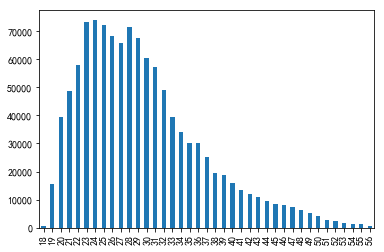

In [101]:
df['age'].value_counts().sort_index().plot(kind='bar',use_index=True)

In [104]:
kmeans = KMeans(n_clusters=8, random_state=2019).fit(df[['age']])

In [107]:
df['age_labels'] = kmeans.labels_

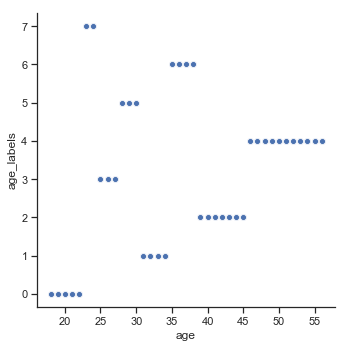

In [114]:
import seaborn as sb
sb.set(style="ticks")
sb.relplot(x='age', y='age_labels', data=df)

In [207]:
train_df=df[:train_num]
train_df['label']=clf_labels

In [225]:
train_df.loc[train_df['hist_interest_mean'].isnull(),'hist_loans']=0

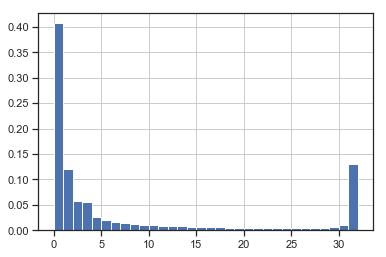

In [291]:
train_df[train_df['hist_loans']<10]['label'].hist(bins=32,density=True)

In [115]:
age_groups = df.groupby('age_labels')

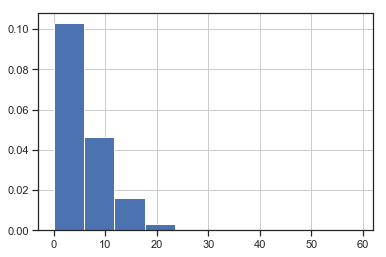

In [304]:
age_groups.get_group(4)['hist_loans'].hist(bins=10,density=True)

In [203]:
age_groups.get_group(5)['early_repay_days_mean'].value_counts().count()

2449

In [152]:
age_group4=age_groups.get_group(5)

In [192]:
age_group4

,user_id,listing_id,auditing_date,due_date,due_amt,principal_per_term_x,hist_loans,hist_interest_mean,hist_interest_median,hist_interest_std,hist_interest_max,hist_interest_min,hist_interest_skew,hist_interest_sum,hist_principal_mean,hist_principal_median,hist_principal_std,hist_principal_max,hist_principal_min,hist_principal_skew,hist_principal_sum,hist_term_mean,hist_term_median,hist_term_std,hist_term_max,hist_term_min,hist_term_skew,hist_term_sum,days_after_last_loan,term,rate,principal,principal_per_term_y,principal_per_term,ttl_due_amt,ttl_interest,interest_per_term,ttl_interest/ttl_due_amt,principal_per_term/due_amt,ttl_interest/principal,due_period,due_amt_per_days,due_date星期几,auditing_date星期几,reg_mon,gender,age,cell_province,id_province,id_city,info_insert_date,time_bt_aud&reg,time_bt_info&reg,cell&id_province_is_same,latest_early_repay_days,latest_(due_amt/early_repay_date),repay_mean,(due_amt/early_repay_date)_mean,(due_amt/early_repay_date)_std,(due_amt/early_repay_date)_median,(due_amt/early_repay_date)_max,(due_amt/early_repay_date)_min,early_repay_days_max,early_repay_days_min,early_repay_days_median,early_repay_days_sum,early_repay_days_mean,early_repay_days_std,age_labels
5,795130,4745662,2018-10-25,2018-11-25,201.0499,279.166667,4.0,13685.312500,11192.708333,10240.165480,27375.833333,4980.000000,0.983503,54741.250000,3480.000000,2805.0,2226.102723,6650.0,1660.0,1.450896,13920.0,10.500000,10.5,1.732051,12.0,9.0,0.000000,42.0,29.0,6,7.6,1180,196.666667,196.666667,1206.2994,26.2994,4.383233,0.021802,0.978198,0.022288,31,6.485481,6,3,2018-02-01,男,30,c31,c31,c31067,2018-10-24,266,265,1,26.0,10.827552,1.000000,14.986608,9.512584,1.591375,25.870450,8.261822,26.0,9.0,22.0,57.0,19.000000,8.888194,5
18,911899,5146879,2018-12-18,2019-01-18,1027.7126,1520.000000,1.0,5472.000000,5472.000000,NaN,5472.000000,5472.000000,NaN,5472.000000,4560.000000,4560.0,NaN,4560.0,4560.0,NaN,4560.0,3.000000,3.0,NaN,3.0,3.0,NaN,3.0,66.0,3,6.5,3050,1016.666667,1016.666667,3083.1378,33.1378,11.045933,0.010748,0.989252,0.010865,31,33.152019,4,1,2018-10-01,女,28,c20,c20,c20249,2018-12-17,78,77,1,2.0,512.758767,1.000000,512.758767,NaN,NaN,512.758767,512.758767,2.0,2.0,2.0,2.0,2.000000,NaN,5
25,488475,5137160,2018-12-17,2019-01-17,483.4584,554.166667,1.0,27375.833333,27375.833333,NaN,27375.833333,27375.833333,NaN,27375.833333,6650.000000,6650.0,NaN,6650.0,6650.0,NaN,6650.0,12.000000,12.0,NaN,12.0,12.0,NaN,12.0,311.0,12,8.6,5540,461.666667,461.666667,5801.5008,261.5008,21.791733,0.045075,0.954925,0.047202,31,15.595432,3,0,2017-04-01,男,28,c23,c26,c26237,2018-12-16,625,624,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,5
26,337408,4517677,2018-09-24,2018-10-24,1389.7108,921.666667,2.0,75372.104167,75372.104167,33730.319288,99223.041667,51521.166667,NaN,150744.208333,16565.000000,16565.0,7785.245661,22070.0,11060.0,NaN,33130.0,12.000000,12.0,0.000000,12.0,12.0,NaN,24.0,75.0,6,8.3,8140,1356.666667,1356.666667,8338.2648,198.2648,33.044133,0.023778,0.976222,0.024357,30,46.323693,2,0,2016-12-01,男,29,c06,c06,c06266,2018-09-23,662,661,1,5.0,160.861917,1.000000,400.916775,339.488836,NaN,640.971633,160.861917,5.0,2.0,3.5,7.0,3.500000,2.121320,5
29,598337,2133470,2018-01-27,2018-02-27,190.6062,330.000000,2.0,2246.812500,2246.812500,1310.710807,3173.625000,1320.000000,NaN,4493.625000,810.000000,810.0,254.558441,990.0,630.0,NaN,1620.0,7.500000,7.5,6.363961,12.0,3.0,NaN,15.0,112.0,6,7.2,1120,186.666667,186.666667,1143.6372,23.6372,3.939533,0.020668,0.979332,0.021105,31,6.148587,1,5,2017-07-01,男,28,c20,c08,c08333,2018-01-26,210,209,0,0.0,334.413000,1.000000,181.002025,216.955881,NaN,334.413000,27.591050,1.0,0.0,0.5,1.0,0.500000,0.707107,5
43,874788,4657822,2018-10-15,2018-11-15,357.5817,210.000000,2.0,3014.666667,3014.666667,3194.237033,5273.333333,756.000000,NaN,6029.333333,1445.000000,1445.0,1152.584053,2260.0,630.0,NaN,2890.0,4.500000,4.5,2.121320,6.0,3.0,NaN,9.0,6.0,3,7.2,1060,353.333333,353.333333,1072.7451,12.7451,4.248367,0.011881,0.988119,0.0120

In [195]:
age_group4[age_group4['early_repay_days_mean']==-1].count()

user_id                              6164
listing_id                           6164
auditing_date                        6164
due_date                             6164
due_amt                              6164
principal_per_term_x                 6164
hist_loans                           6164
hist_interest_mean                   6164
hist_interest_median                 6164
hist_interest_std                    3519
hist_interest_max                    6164
hist_interest_min                    6164
hist_interest_skew                   2111
hist_interest_sum                    6164
hist_principal_mean                  6164
hist_principal_median                6164
hist_principal_std                   3519
hist_principal_max                   6164
hist_principal_min                   6164
hist_principal_skew                  2111
hist_principal_sum                   6164
hist_term_mean                       6164
hist_term_median                     6164
hist_term_std                     

# 处理类别特征和日期

In [104]:
cate_cols = ['gender', 'cell_province', 'id_province', 'id_city']

In [105]:
# 这个lgb应该有参数可以直接传 lgb.train(categorical_feature=cate_cols)
for f in cate_cols:
    df[f] = df[f].map(dict(zip(df[f].unique(), range(df[f].nunique())))).astype('int32')

In [107]:
date_cols = ['auditing_date', 'due_date', 'reg_mon', 'info_insert_date', 'tag_insert_date']

In [108]:
for f in date_cols:
    if f in ['reg_mon', 'info_insert_date', 'tag_insert_date']:
        df[f + '_year'] = df[f].dt.year
    df[f + '_month'] = df[f].dt.month
    if f in ['auditing_date', 'due_date', 'info_insert_date', 'tag_insert_date']:
        df[f + '_day'] = df[f].dt.day
        df[f + '_dayofweek'] = df[f].dt.dayofweek

In [109]:
df.drop(columns=date_cols, axis=1, inplace=True)

In [110]:
df['big_month'] = df['auditing_date_month'].apply(lambda x: 1 if x in [1,3,5,7,8,10,12] else 0)
df['February'] = df['auditing_date_month'].apply(lambda x: 1 if x==2 else 0)

In [111]:
# one-hot encoding for tags
df['taglist'] = df['taglist'].astype('str').apply(lambda x: x.strip().replace('|', ' ').strip())

In [112]:
vectorizer = CountVectorizer(min_df=10, max_df=0.9)
tag_cv = vectorizer.fit_transform(df['taglist'])

In [113]:
del df['user_id'], df['listing_id'], df['taglist']

In [114]:
# 也可以用lgb.train(categorical_features=cate_cols)
df = pd.get_dummies(df, columns=cate_cols)
df = pd.get_dummies(df, columns=cate_cols2)

# 训练模型

In [115]:
feature_name = np.concatenate((df.keys(),vectorizer.get_feature_names()))

In [116]:
df = sparse.hstack((df.values, tag_cv), format='csr', dtype='float32')

In [117]:
train_values, test_values = df[:train_num], df[train_num:]

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)
clf = LGBMClassifier(
    n_jobs=87,
    learning_rate=0.05,
    n_estimators=10000,
    subsample=0.8,
    subsample_freq=1,
    colsample_bytree=0.8,
    random_state=2019
)
amt_oof = np.zeros(train_num)
prob_oof = np.zeros((train_num, 33))
test_pred_prob = np.zeros((test_values.shape[0], 33))
for i, (trn_idx, val_idx) in enumerate(skf.split(train_values, clf_labels)):
    print(i, 'fold...')
    t = time.time()

    trn_x, trn_y = train_values[trn_idx], clf_labels[trn_idx]
    val_x, val_y = train_values[val_idx], clf_labels[val_idx]
    val_repay_amt = amt_labels[val_idx]
    val_due_amt = train_due_amt_df.iloc[val_idx]

    clf.fit(
        trn_x, trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        early_stopping_rounds=100, verbose=5, feature_name=list(feature_name)
    )
    # shape = (-1, 33)
    val_pred_prob_everyday = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
    prob_oof[val_idx] = val_pred_prob_everyday
    val_pred_prob_today = [val_pred_prob_everyday[i][val_y[i]] for i in range(val_pred_prob_everyday.shape[0])]
    val_pred_repay_amt = val_due_amt['due_amt'].values * val_pred_prob_today
    print('val rmse:', np.sqrt(mean_squared_error(val_repay_amt, val_pred_repay_amt)))
    print('val mae:', mean_absolute_error(val_repay_amt, val_pred_repay_amt))
    amt_oof[val_idx] = val_pred_repay_amt
    test_pred_prob += clf.predict_proba(test_values, num_iteration=clf.best_iteration_) / skf.n_splits

    print('runtime: {}\n'.format(time.time() - t))

print('\ncv rmse:', np.sqrt(mean_squared_error(amt_labels, amt_oof)))
print('cv mae:', mean_absolute_error(amt_labels, amt_oof))
print('cv logloss:', log_loss(clf_labels, prob_oof))
print('cv acc:', accuracy_score(clf_labels, np.argmax(prob_oof, axis=1)))

0 fold...
Training until validation scores don't improve for 100 rounds.
[5]	valid_0's multi_logloss: 2.95328	valid_1's multi_logloss: 2.95586
[10]	valid_0's multi_logloss: 2.71521	valid_1's multi_logloss: 2.72023
[15]	valid_0's multi_logloss: 2.5645	valid_1's multi_logloss: 2.57185
[20]	valid_0's multi_logloss: 2.45895	valid_1's multi_logloss: 2.46867
[25]	valid_0's multi_logloss: 2.3811	valid_1's multi_logloss: 2.39316
[30]	valid_0's multi_logloss: 2.32191	valid_1's multi_logloss: 2.33633
[35]	valid_0's multi_logloss: 2.27583	valid_1's multi_logloss: 2.29266
[40]	valid_0's multi_logloss: 2.23933	valid_1's multi_logloss: 2.25861
[45]	valid_0's multi_logloss: 2.21003	valid_1's multi_logloss: 2.23181
[50]	valid_0's multi_logloss: 2.18617	valid_1's multi_logloss: 2.21056
[55]	valid_0's multi_logloss: 2.16659	valid_1's multi_logloss: 2.19357
[60]	valid_0's multi_logloss: 2.15025	valid_1's multi_logloss: 2.17987
[65]	valid_0's multi_logloss: 2.13643	valid_1's multi_logloss: 2.16884
[70]	va

[65]	valid_0's multi_logloss: 2.13619	valid_1's multi_logloss: 2.16898
[70]	valid_0's multi_logloss: 2.12441	valid_1's multi_logloss: 2.16004
[75]	valid_0's multi_logloss: 2.1142	valid_1's multi_logloss: 2.15276
[80]	valid_0's multi_logloss: 2.1052	valid_1's multi_logloss: 2.14676
[85]	valid_0's multi_logloss: 2.09723	valid_1's multi_logloss: 2.14186
[90]	valid_0's multi_logloss: 2.09009	valid_1's multi_logloss: 2.13783
[95]	valid_0's multi_logloss: 2.08358	valid_1's multi_logloss: 2.13451
[100]	valid_0's multi_logloss: 2.07757	valid_1's multi_logloss: 2.1318
[105]	valid_0's multi_logloss: 2.07199	valid_1's multi_logloss: 2.12951
[110]	valid_0's multi_logloss: 2.06679	valid_1's multi_logloss: 2.12763
[115]	valid_0's multi_logloss: 2.06186	valid_1's multi_logloss: 2.12603
[120]	valid_0's multi_logloss: 2.05721	valid_1's multi_logloss: 2.12472
[125]	valid_0's multi_logloss: 2.05271	valid_1's multi_logloss: 2.1236
[130]	valid_0's multi_logloss: 2.04841	valid_1's multi_logloss: 2.12268
[13

[155]	valid_0's multi_logloss: 2.02819	valid_1's multi_logloss: 2.12125
[160]	valid_0's multi_logloss: 2.02456	valid_1's multi_logloss: 2.1209
[165]	valid_0's multi_logloss: 2.02107	valid_1's multi_logloss: 2.12059
[170]	valid_0's multi_logloss: 2.01763	valid_1's multi_logloss: 2.12034
[175]	valid_0's multi_logloss: 2.01424	valid_1's multi_logloss: 2.12006
[180]	valid_0's multi_logloss: 2.01095	valid_1's multi_logloss: 2.11988
[185]	valid_0's multi_logloss: 2.00774	valid_1's multi_logloss: 2.11969
[190]	valid_0's multi_logloss: 2.00448	valid_1's multi_logloss: 2.11953
[195]	valid_0's multi_logloss: 2.00133	valid_1's multi_logloss: 2.11935
[200]	valid_0's multi_logloss: 1.99821	valid_1's multi_logloss: 2.11922
[205]	valid_0's multi_logloss: 1.99519	valid_1's multi_logloss: 2.11914
[210]	valid_0's multi_logloss: 1.99217	valid_1's multi_logloss: 2.11906
[215]	valid_0's multi_logloss: 1.98925	valid_1's multi_logloss: 2.11898
[220]	valid_0's multi_logloss: 1.98631	valid_1's multi_logloss: 2

[210]	valid_0's multi_logloss: 1.99273	valid_1's multi_logloss: 2.11727
[215]	valid_0's multi_logloss: 1.98975	valid_1's multi_logloss: 2.11715
[220]	valid_0's multi_logloss: 1.98686	valid_1's multi_logloss: 2.117
[225]	valid_0's multi_logloss: 1.98401	valid_1's multi_logloss: 2.1169
[230]	valid_0's multi_logloss: 1.98123	valid_1's multi_logloss: 2.11679
[235]	valid_0's multi_logloss: 1.9785	valid_1's multi_logloss: 2.11669
[240]	valid_0's multi_logloss: 1.97576	valid_1's multi_logloss: 2.11664
[245]	valid_0's multi_logloss: 1.97304	valid_1's multi_logloss: 2.11656
[250]	valid_0's multi_logloss: 1.97035	valid_1's multi_logloss: 2.11651
[255]	valid_0's multi_logloss: 1.96776	valid_1's multi_logloss: 2.11646
[260]	valid_0's multi_logloss: 1.96514	valid_1's multi_logloss: 2.11644
[265]	valid_0's multi_logloss: 1.96249	valid_1's multi_logloss: 2.11639
[270]	valid_0's multi_logloss: 1.95996	valid_1's multi_logloss: 2.11636
[275]	valid_0's multi_logloss: 1.95745	valid_1's multi_logloss: 2.11

In [ ]:
# # 原本的输出
# prob_cols = ['prob_{}'.format(i) for i in range(33)]
# for i, f in enumerate(prob_cols):
#     sub[f] = test_pred_prob[:, i]
# sub_example = pd.read_csv('dataset/submission.csv', parse_dates=['repay_date'])
# sub_example = sub_example.merge(sub, on='listing_id', how='left')
# sub_example['days'] = (sub_example['repay_date'] - sub_example['auditing_date']).dt.days
# # shape = (-1, 33)
# test_prob = sub_example[prob_cols].values
# test_labels = sub_example['days'].values
# test_prob = [test_prob[i][test_labels[i]] for i in range(test_prob.shape[0])]
# sub_example['repay_amt'] = sub_example['due_amt'] * test_prob
# sub_example[['listing_id', 'repay_date', 'repay_amt']].to_csv('sub.csv', index=False)



In [ ]:
import pickle
with open("test_pred_prob6.pkl", 'wb') as f:
    pickle.dump(test_pred_prob, f)

In [ ]:
prob_cols = ['prob_{}'.format(i) for i in range(33)]

In [ ]:
for i, f in enumerate(prob_cols):
    sub[f] = test_pred_prob[:, i]

In [ ]:
sub_example = pd.read_csv('dataset/submission.csv', parse_dates=['repay_date'])

In [ ]:
sub_example = sub_example.merge(sub, on='listing_id', how='left')

In [ ]:
def add_1_month(s):
    s = s.strftime('%F')
    y, m, d = str(s).split('-')
    y = int(y)
    m = int(m)
    d = int(d)
    m = m + 1
    if m == 13:
        m = 1
        y = y + 1
    if m in [4,6,9,11]:
        if d == 31:
            d = 30
    if m == 2:
        if d in [29, 30, 31]:
            if y in [2012, 2016]:
                d = 29
            else:
                d = 28
    return datetime.datetime.strptime(str(y)+'-'+str(m)+'-'+str(d), '%Y-%m-%d')

In [ ]:
from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()

In [ ]:
sub_example['due_date'] = sub_example['auditing_date'].parallel_apply(add_1_month)

In [ ]:
sub_example.head()

In [ ]:
sub_example['days'] = (sub_example['due_date'] - sub_example['repay_date']).dt.days

In [ ]:
sub_example.head()

In [ ]:
test_prob = sub_example[prob_cols].values

In [ ]:
test_labels = sub_example['days'].values

In [ ]:
test_prob = [test_prob[i][test_labels[i]] for i in range(test_prob.shape[0])]

In [ ]:
sub_example['repay_amt'] = sub_example['due_amt'] * test_prob

In [ ]:
sub_example[['listing_id', 'repay_date', 'repay_amt']].to_csv(f"sub_{datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')}.csv", index=False)

In [ ]:
lgb.plot_importance(clf, max_num_features=50,figsize=(10,10))

In [ ]:
sub_example['prob'] = test_prob

In [ ]:
threshold_up = 0.57
id_with_highpro = sub_example[sub_example['prob']>=threshold_up]['listing_id']

In [ ]:
sub_example.loc[sub_example['listing_id'].isin(id_with_highpro.values),'repay_amt']=0

In [ ]:
sub_example['repay_amt']= sub_example.apply(lambda x:x['repay_amt'] if x['prob']<threshold_up else x['due_amt'],axis=1)

In [ ]:
sub_example[['listing_id', 'repay_date', 'repay_amt']].to_csv(f"sub_{datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')}_0_{threshold_up}.csv", index=False)

In [ ]:
sub_example.groupby('repay_date').apply(lambda x:x['repay_amt'].sum()).plot(kind='line')

def alter(df, date, a):
    """
    data就是要增加的日期
    a就是这天增加的比例
    """
    if date not in df['repay_date'].values:
        return df
    else:
        dates = df['repay_date'].tolist()
        dates.remove(date)
        df = df.set_index('repay_date')
        b = df.loc[date, 'repay_amt'] * a
        df.loc[date, 'repay_amt'] += b
        df.loc[dates, 'repay_amt'] -= b / len(dates)
        df.reset_index(inplace=True)
        return df

sub_example_1 = sub_example.copy()

sub_example_1['repay_date']=sub_example_1['repay_date'].astype(str)

sub_example_1 = sub_example_1.groupby('listing_id', as_index=False).apply(alter, date="2019-03-29", a=0.1).reset_index(drop=True)[['listing_id', 'repay_date', 'repay_amt']]
sub_example_1 = sub_example_1.groupby('listing_id', as_index=False).apply(alter, date="2019-03-30", a=0.1).reset_index(drop=True)[['listing_id', 'repay_date', 'repay_amt']]
sub_example_1 = sub_example_1.groupby('listing_id', as_index=False).apply(alter, date="2019-03-31", a=0.1).reset_index(drop=True)[['listing_id', 'repay_date', 'repay_amt']]

sub_example_1.to_csv("sub_ex.csv",index=False)

# 下面这行的结果告诉我一下

In [ ]:
#df_bkup = sub_example.copy()

In [ ]:
#sub_example['prob'] = test_prob 

In [ ]:
#sub_example.sort_values(by='prob',ascending = False).drop_duplicates('listing_id').reset_index(drop=True).prob.describe()

In [ ]:
#for threshold in [0.1, 0.15, 0.2, 0.25]:  # 这里的threshold可以根据上面给我看的describe进行修改
#    sub_example['repay_amt'] = sub_example.apply(lambda x:x['due_amt'] * x['prob'] if x['prob'] > threshold else 0, axis=1)
#    sub_example[['listing_id', 'repay_date', 'repay_amt']].to_csv(f"sub_{datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')}_{threshold}.csv", index=False)


In [ ]:
#for threshold in [0.1, 0.15, 0.2, 0.25]:  # 这里的threshold可以根据上面给我看的describe进行修改
#    sub_example['repay_amt'] = sub_example.apply(lambda x:x['due_amt'] * x['prob'] if x['prob'] > threshold else 0, axis=1)
#    sub_example_fin=sub_example[['listing_id', 'repay_date', 'repay_amt']]
#    sub_example_fin[sub_example_fin['repay_amt']!=0].to_csv(f"sub_{datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')}_{threshold}.csv", index=False)